# Supreme Court Oral Argument Prediction
## CAPP254. Final Project. Checkpoint 1

Diamon Dunlap, Betty Fang, Megan Moore, Angel Rodriguez 

In [84]:
from convokit import Corpus, Conversation, Utterance, Speaker, FightingWords, download
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import json
import re

### Part 1. Load Data and Filter the Dataset
We chose the Roberts-4 natural court and the Rehnquist-7 natural court based on the information here (http://scdb.wustl.edu/documentation.php?var=naturalCourt) in order to analyze two relatively recent courts that had a sufficient number of cases so as to be able to make generalizable takeaways. From the research that has analyzed this topic before, we determined that  there seems to be a lot of variation in words used and speaking patterns, depending on who the justice is. Therefore in order to maintain consistency of speaking patterns we want to isolate our dataset to a consistent group of judges. We chose to select two courts so that we can potentially do cross validation as to whether certain patterns are valid across courts and to be able to do predictive analysis on out of sample data.


In [126]:
# First, we load the data for the full years, for both courts

rehnquist_full_years = [i for i in range(1994,2006)]
rehnquist_corpus = None
for year in rehnquist_full_years:
    corp = Corpus(filename=download(f"supreme-{year}"))
    if not rehnquist_corpus:
        rehnquist_corpus = corp
    else:
        rehnquist_corpus = Corpus.merge(rehnquist_corpus, corp)

roberts_full_years = [i for i in range(2010,2017)]
roberts_corpus = None
for year in roberts_full_years:
    corp = Corpus(filename=download(f"supreme-{year}"))
    if not roberts_corpus:
        roberts_corpus = corp
    else:
        roberts_corpus = Corpus.merge(roberts_corpus, corp)


# Second, we filter out the cases that belong to the previous or the following court

with open('../data/cases.json', "r") as f:
    data = [json.loads(line) for line in f]
    begin_date_rehn7 = datetime.strptime('Aug 3, 1994', '%b %d, %Y')
    end_date_rehn7 = datetime.strptime('Sep 28, 2005','%b %d, %Y')
    begin_date_rob4 = datetime.strptime('Aug 7, 2010', '%b %d, %Y')
    end_date_rob4 = datetime.strptime('Feb 13, 2016', '%b %d, %Y')
    case_ids_rehn7 = []
    case_ids_rob4 = []
    for case in data:
        str_date = case["decided_date"]
        if isinstance(str_date, str):
            num_date = datetime.strptime(str_date, '%b %d, %Y')
            if num_date >= begin_date_rehn7 and num_date <= end_date_rehn7:
                case_ids_rehn7.append(case["id"])
            if num_date >= begin_date_rob4 and num_date <= end_date_rob4:
                case_ids_rob4.append(case["id"])
with open('../data/filtered_cases.json', "w") as f2:
    json.dump({"rehn7": case_ids_rehn7,"rob4": case_ids_rob4}, f2, indent=1)

rehnquist_corpus = rehnquist_corpus.filter_conversations_by(lambda u: str(u.meta["case_id"]) in case_ids_rehn7)
roberts_corpus = roberts_corpus.filter_conversations_by(lambda u: u.meta["case_id"] in case_ids_rob4)


Dataset already exists at C:\Users\Propietario\.convokit\downloads\supreme-1994
Dataset already exists at C:\Users\Propietario\.convokit\downloads\supreme-1995
Dataset already exists at C:\Users\Propietario\.convokit\downloads\supreme-1996
Dataset already exists at C:\Users\Propietario\.convokit\downloads\supreme-1997
Dataset already exists at C:\Users\Propietario\.convokit\downloads\supreme-1998
Dataset already exists at C:\Users\Propietario\.convokit\downloads\supreme-1999
Dataset already exists at C:\Users\Propietario\.convokit\downloads\supreme-2000
Dataset already exists at C:\Users\Propietario\.convokit\downloads\supreme-2001
Dataset already exists at C:\Users\Propietario\.convokit\downloads\supreme-2002
Dataset already exists at C:\Users\Propietario\.convokit\downloads\supreme-2003
Dataset already exists at C:\Users\Propietario\.convokit\downloads\supreme-2004
Dataset already exists at C:\Users\Propietario\.convokit\downloads\supreme-2005
Dataset already exists at C:\Users\Propi

In [125]:
print('Rehnquist-7 corpus:')
rehnquist_corpus.print_summary_stats()

print('\nRoberts-4 corpus:')
roberts_corpus.print_summary_stats()

Rehnquist-7 corpus:
Number of Speakers: 1231
Number of Utterances: 224916
Number of Conversations: 866

Roberts-4 corpus:
Number of Speakers: 432
Number of Utterances: 80087
Number of Conversations: 361


Every convokit.Corpus has three main components: Conversations, Utterances, and Speakers. We print one example for each (from the rehnquist_corpus) to illustrate the different attributes of theses classes.

In [90]:
print('Example of a conversation:\n', rehnquist_corpus.random_conversation())

print('\nExample of an utterance:\n', rehnquist_corpus.random_utterance())

print('\nExample of a speaker:\n', rehnquist_corpus.random_speaker())

Example of a conversation:
 Conversation('id': '22523', 'utterances': ['22523__0_000', '22523__0_001', '22523__0_002', '22523__0_003', '22523__0_004', '22523__0_005', '22523__0_006', '22523__0_007', '22523__0_008', '22523__0_009', '22523__0_010', '22523__0_011', '22523__0_012', '22523__0_013', '22523__0_014', '22523__0_015', '22523__0_016', '22523__0_017', '22523__0_018', '22523__0_019', '22523__0_020', '22523__0_021', '22523__0_022', '22523__0_023', '22523__0_024', '22523__0_025', '22523__0_026', '22523__0_027', '22523__0_028', '22523__0_029', '22523__0_030', '22523__0_031', '22523__0_032', '22523__0_033', '22523__0_034', '22523__0_035', '22523__0_036', '22523__0_037', '22523__0_038', '22523__0_039', '22523__0_040', '22523__0_041', '22523__0_042', '22523__0_043', '22523__0_044', '22523__0_045', '22523__0_046', '22523__0_047', '22523__0_048', '22523__0_049', '22523__0_050', '22523__0_051', '22523__0_052', '22523__0_053', '22523__0_054', '22523__0_055', '22523__0_056', '22523__0_057', '

In [119]:
# Third, we build a dataframe for each court...

cases_df = pd.read_json('../data/cases.json', lines=True)
roberts_cases = cases_df.loc[cases_df.loc[:, 'year'].isin(roberts_full_years)]
renquist_cases = cases_df.loc[cases_df.loc[:, 'year'].isin(rehnquist_full_years)]


# ... and we split each of them into wins and losses

rehnquist_convo_df= rehnquist_corpus.get_conversations_dataframe()
rehnquist_wins_df = rehnquist_convo_df.loc[rehnquist_convo_df.loc[:, 'meta.win_side'] == 1, :]
rehnquist_losses_df = rehnquist_convo_df.loc[rehnquist_convo_df.loc[:, 'meta.win_side'] == 0, :]

roberts_convo_df= roberts_corpus.get_conversations_dataframe()
roberts_wins_df = roberts_convo_df.loc[roberts_convo_df.loc[:, 'meta.win_side'] == 1, :]
roberts_losses_df = roberts_convo_df.loc[roberts_convo_df.loc[:, 'meta.win_side'] == 0, :]

In [120]:
# check that there are no incorrect case ids in the corpus and see how 
# many cases we don't have a record of in the corpus
corpus_case_ids = rehnquist_convo_df.loc[:, 'meta.case_id'].unique()
cases_ids = list(cases_df.loc[cases_df.loc[:, 'year'].isin(rehnquist_full_years), 'id'].unique())
num_diff = len(cases_ids)-len(corpus_case_ids) # num missing conversations 
discrepancies = [i for i in cases_ids if i not in corpus_case_ids]
corp_not_case = [i for i in corpus_case_ids if i not in cases_ids]
print(discrepancies, num_diff, corp_not_case, len(corpus_case_ids))
# all case ids in the corpus are valid case ids in the case_ids
# there are 90 missing cases that are not 

['1994_93-1462', '1994_93-1783', '1994_94-941', '1994_94-898', '1994_93-9220', '1994_94-802', '1994_93-1577', '1994_94-7743', '1995_95-6710', '1995_95-1612', '1995_95-1025', '1995_95-7186', '1995_94-9323', '1995_95-1242', '1995_95-7587', '1995_95-1691', '1995_94-8988', '1995_95-6016', '1995_35-orig', '1995_94-1419', '1996_95-1425', '1996_96-713', '1996_95-2025', '1996_96-987', '1996_96-5369', '1996_96-5831', '1996_96-8005', '1996_96-858', '1996_96-1033', '1996_96-1104', '1996_96-1383', '1996_95-2082', '1996_95-1906', '1996_96-8796', '1997_97-6749', '1997_97-8214', '1997_97-5370', '1997_97-122', '1997_97-7300', '1997_97-954', '1997_97-1217', '1997_97-663', '1998_98-437', '1998_98-1071', '1998_98-8486', '1998_127-orig', '1998_98-8952', '1998_98-6945', '1998_98-7591', '1998_98-1062', '1998_120-orig', '1998_98-7450', '1998_98-7771', '1998_98-1412', '1998_98-9085', '1998_98-83', '1999_99-295', '1999_98-9933', '1999_98-9913', '1999_99-5283', '1999_98-8770', '1999_99-5440', '1999_99-5260', '1

In [121]:
# cases that are duplicated in the rehnquist corpus, there are only 3 cases that have 
# multiple conversation entries in the corpus, if we do anything that weights wins/losses by conversation
# then we need to take this into consideration because there will be double counting of win/loss for these case ids
unique_ids = []
dup_ids = {}
for case_id in rehnquist_convo_df.loc[:, 'meta.case_id']:
    if case_id in unique_ids:
        if case_id in dup_ids.keys():
            dup_ids[case_id] += 1
        else:
            dup_ids[case_id] = 1
    else:
        unique_ids.append(case_id)
dup_ids.keys()
dup_ids

{'1999_98-6322': 1, '2000_99-1257': 1, '2003_02-1674': 1}

In [115]:
# check that there are no incorrect case ids in the corpus and see how 
# many cases we don't have a record of in the corpus
corpus_case_ids = roberts_convo_df.loc[:, 'meta.case_id'].unique()
cases_ids = list(cases_df.loc[cases_df.loc[:, 'year'].isin(roberts_full_years), 'id'].unique())
num_diff = len(cases_ids)-len(corpus_case_ids) # num missing conversations 
discrepancies = [i for i in cases_ids if i not in corpus_case_ids]
corp_not_case = [i for i in corpus_case_ids if i not in cases_ids]
print(discrepancies, num_diff, corp_not_case, len(corpus_case_ids))
# all case ids in the corpus are valid case ids in the case_ids
# there are 67 missing cases that are not 

['2010_10-1000', '2010_10-72', '2010_10-514', '2010_09-940', '2011_11-1179', '2011_10-1540', '2011_10-1115', '2011_11-1053', '2011_11-74', '2011_10-1521', '2011_10-1032', '2011_11-391', '2011_11-845', '2011_11-208', '2011_11-1184', '2011_11-38', '2012_12-168', '2012_12-382', '2012_12-694', '2012_11-1377', '2012_12-1084', '2012_12-1208', '2012_12-623', '2013_13-299', '2013_12-1094', '2013_13-113', '2013_13-6440', '2013_13-5967', '2013_11-1507', '2013_13-640', '2013_12-992', '2013_12-1217', '2013_13-551', '2013_13-301', '2013_13-9085', '2014_13-1421', '2014_13-1433', '2014_14-116', '2014_14-212', '2014_13-10400', '2014_14-6873', '2014_13-1412', '2014_13-896', '2014_14-95', '2014_14-593', '2014_14-400', '2014_14-275', '2014_13-7211', '2014_13-1318', '2014_126-orig', '2014_13-720', '2014_13-946', '2014_14-378', '2014_14-46', '2014_13-534', '2014_14-939', '2014_14-6381', '2014_14-618', '2015_14-1382', '2015_15-278', '2015_14-770', '2015_14-1457', '2015_14-1468', '2015_14-10078', '2015_14-13

In [116]:
# cases that are duplicated in the roberts corpus, there are only 8 cases that have 
# multiple conversation entries in the corpus, if we do anything that weights wins/losses by conversation
# then we need to take this into consideration because there will be double counting of win/loss for these case ids
unique_ids = []
dup_ids = {}
for case_id in roberts_convo_df.loc[:, 'meta.case_id']:
    if case_id in unique_ids:
        if case_id in dup_ids.keys():
            dup_ids[case_id] += 1
        else:
            dup_ids[case_id] = 1
    else:
        unique_ids.append(case_id)
dup_ids

{'2011_10-1491': 1,
 '2011_10-9646': 1,
 '2011_11-393': 3,
 '2012_10-930': 1,
 '2013_13-132': 1,
 '2014_13-7120': 1,
 '2014_14-556': 1,
 '2015_14-449': 1}

### Part 2. Exploratory Analysis: Descriptive Statistics

**2.1. CASES**

We get the number of cases per year, for both natural courts. These are relatively stable and similar in both ranges (note that the extrema are not complete years).

We also get the cases whose verdict is favorable to the petitioner and to the respondent. For both natural courts, the petitioner wins the case more frequently.

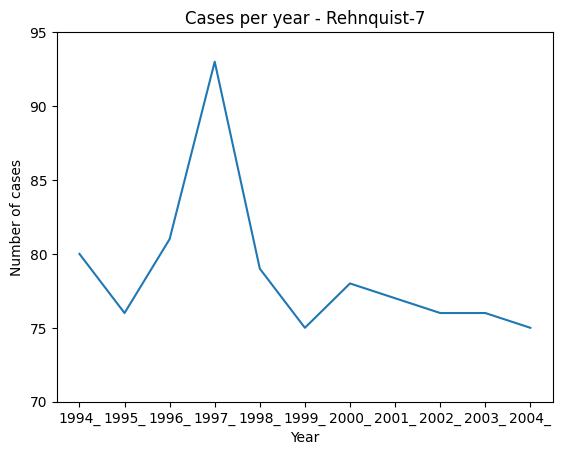

In [127]:
cases_win_rehnquist = dict()
cases_pyr_rehnquist = dict()
for conv in rehnquist_corpus.iter_conversations():
    year = str(conv.meta['case_id'])[0:5]
    if year not in cases_pyr_rehnquist:
        cases_pyr_rehnquist[year] = 1
    else:
        cases_pyr_rehnquist[year] += 1
        
    id = str(conv.meta['case_id'])
    if id not in cases_win_rehnquist:
        cases_win_rehnquist[id] = conv.meta['win_side']
    elif cases_win_rehnquist[id] == 0 or cases_win_rehnquist[id] == 1:
        continue
    else:
        cases_win_rehnquist[id] = conv.meta['win_side']


years = list(cases_pyr_rehnquist.keys())
cases = list(cases_pyr_rehnquist.values())

plt.plot(years, cases)
plt.ylim(70, 95)
plt.xlabel('Year')
plt.ylabel('Number of cases')
plt.title('Cases per year - Rehnquist-7')
plt.show()

In [128]:
cases_win_agg_rehnquist = dict()
for k,v in cases_win_rehnquist.items():
    if v not in cases_win_agg_rehnquist:
        cases_win_agg_rehnquist[v] = 1
    else:
        cases_win_agg_rehnquist[v] += 1
print('TOTAL Natural Court (Rehnquist-7):' , cases_win_agg_rehnquist, ',', '\nwhere (0,1) = (respondent, petitioner)')

TOTAL Natural Court (Rehnquist-7): {1: 543, 0: 318, 2: 1, None: 1} , 
where (0,1) = (respondent, petitioner)


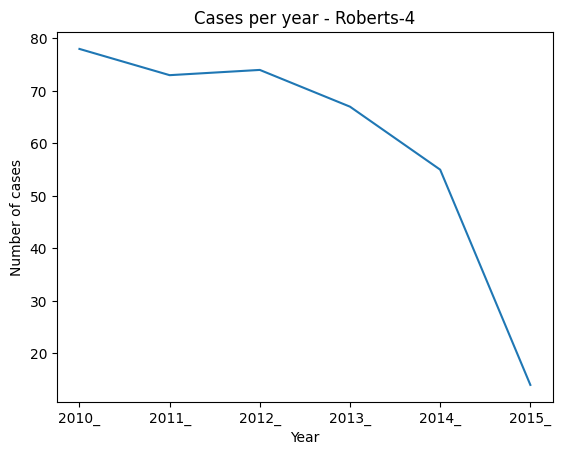

In [129]:
cases_win_roberts = dict()
cases_pyr_roberts = dict()

for conv in roberts_corpus.iter_conversations():
    year = str(conv.meta['case_id'])[0:5]
    if year not in cases_pyr_roberts:
        cases_pyr_roberts[year] = 1
    else:
        cases_pyr_roberts[year] += 1

    id = str(conv.meta['case_id'])
    if id not in cases_win_roberts:
        cases_win_roberts[id] = conv.meta['win_side']
    elif cases_win_roberts[id] == 0 or cases_win_roberts[id] == 1:
        continue
    else:
        cases_win_roberts[id] = conv.meta['win_side']


years = list(cases_pyr_roberts.keys())
cases = list(cases_pyr_roberts.values())

plt.plot(years, cases)
plt.xlabel('Year')
plt.ylabel('Number of cases')
plt.title('Cases per year - Roberts-4')
plt.show()

In [130]:
cases_win_agg_roberts = dict()
for k,v in cases_win_roberts.items():
    if v not in cases_win_agg_roberts:
        cases_win_agg_roberts[v] = 1
    else:
        cases_win_agg_roberts[v] += 1
print('TOTAL Natural Court (Roberts-4):' , cases_win_agg_roberts, ',', '\nwhere (0,1) = (respondent, petitioner)')

TOTAL Natural Court (Roberts-4): {0: 126, 1: 225} , 
where (0,1) = (respondent, petitioner)


**2.2. SPEAKERS**

We build a dataframe with all the speakers in all cases for each natural court; this includes both the justices and the advocates.

We also build a dataframe with the relative frequency each judge votes for the petitioner and the relative frequency he/she dissents with the rest of judges. There is little dispersion as far as the first is concerned, but non-negligible differences for the latter.

We also look for possible differences in the lenght (in seconds) and the number of times each judge intervenes in each natural court. We plot this in 4 graphs.

In [131]:
display(rehnquist_corpus.get_speakers_dataframe())
display(roberts_corpus.get_speakers_dataframe())

,vectors,meta.name,meta.type,meta.role
id,,,,
j__william_h_rehnquist,[],William H. Rehnquist,J,justice
william_perry_pendley,[],William Perry Pendley,A,NaN
j__antonin_scalia,[],Antonin Scalia,J,justice
j__david_h_souter,[],David H. Souter,J,justice
j__ruth_bader_ginsburg,[],Ruth Bader Ginsburg,J,justice
...,...,...,...,...
jonathan_l_marcus,[],Jonathan L. Marcus,A,NaN
james_m_petro,[],James M. Petro,A,NaN
deanne_e_maynard,[],Deanne E. Maynard,A,NaN


,vectors,meta.name,meta.type,meta.role
id,,,,
j__john_g_roberts_jr,[],"John G. Roberts, Jr.",J,justice
david_l_horan,[],David L. Horan,A,NaN
j__samuel_a_alito_jr,[],"Samuel A. Alito, Jr.",J,justice
j__ruth_bader_ginsburg,[],Ruth Bader Ginsburg,J,justice
j__sonia_sotomayor,[],Sonia Sotomayor,J,justice
...,...,...,...,...
mark_d_plaisance,[],Mark D. Plaisance,A,NaN
erik_s_jaffe,[],Erik S. Jaffe,A,NaN
juan_c_basombrio,[],Juan C. Basombrio,A,NaN


In [107]:
votes_count_rehnquist = dict()
dissent_count_rehnquist = dict()
conv_num_rehnquist = 0
for conv in rehnquist_corpus.iter_conversations():
    if isinstance(conv.meta['votes_side'], dict):
        for just in conv.meta['votes_side']:
            if just not in votes_count_rehnquist and conv.meta['votes_side'][just] == 1:
                votes_count_rehnquist[just] = 1
            elif conv.meta['votes_side'][just] == 1:
                votes_count_rehnquist[just] += 1
        verdict = conv.meta['win_side']
        for just in conv.meta['votes_side']:
            if just not in dissent_count_rehnquist and conv.meta['votes_side'][just] != verdict:
                dissent_count_rehnquist[just] = 1
            elif conv.meta['votes_side'][just] != verdict:
                dissent_count_rehnquist[just] += 1
    conv_num_rehnquist += 1

for jus,vot in votes_count_rehnquist.items():
    votes_count_rehnquist[jus]=round(vot/conv_num_rehnquist,4)

for jus,dis in dissent_count_rehnquist.items():
    dissent_count_rehnquist[jus]=round(dis/conv_num_rehnquist,4)

j_positions_rehnquist = pd.DataFrame({'petitioner': votes_count_rehnquist, 'dissent': dissent_count_rehnquist})
print('Judges positions under Rehnquist-7')
display(j_positions_rehnquist)

Judges positions under Rehnquist-7


,petitioner,dissent
j__william_h_rehnquist,0.6005,0.1513
j__sandra_day_oconnor,0.6270,0.1051
j__antonin_scalia,0.5866,0.2194
j__anthony_m_kennedy,0.6247,0.1062
j__clarence_thomas,0.5716,0.2125
j__john_paul_stevens,0.5635,0.2714
j__david_h_souter,0.5901,0.1848
j__ruth_bader_ginsburg,0.5785,0.2079
j__stephen_g_breyer,0.6189,0.1894


In [108]:
votes_count_roberts = dict()
dissent_count_roberts = dict()
conv_num_roberts = 0
for conv in roberts_corpus.iter_conversations():
    if isinstance(conv.meta['votes_side'], dict):
        for just in conv.meta['votes_side']:
            if just not in votes_count_roberts and conv.meta['votes_side'][just] == 1:
                votes_count_roberts[just] = 1
            elif conv.meta['votes_side'][just] == 1:
                votes_count_roberts[just] += 1
        verdict = conv.meta['win_side']
        for just in conv.meta['votes_side']:
            if just not in dissent_count_roberts and conv.meta['votes_side'][just] != verdict:
                dissent_count_roberts[just] = 1
            elif conv.meta['votes_side'][just] != verdict:
                dissent_count_roberts[just] += 1
    conv_num_roberts += 1

for jus,vot in votes_count_roberts.items():
    votes_count_roberts[jus]=round(vot/conv_num_roberts,4)

for jus,dis in dissent_count_roberts.items():
    dissent_count_roberts[jus]=round(dis/conv_num_roberts,4)

j_positions_roberts = pd.DataFrame({'petitioner': votes_count_roberts, 'dissent': dissent_count_roberts})
print('Judges positions under Roberts-4')
display(j_positions_roberts)

Judges positions under Roberts-4


,petitioner,dissent
j__john_g_roberts_jr,0.6150,0.1330
j__antonin_scalia,0.6066,0.2161
j__anthony_m_kennedy,0.6399,0.0942
j__clarence_thomas,0.5651,0.2244
j__ruth_bader_ginsburg,0.5956,0.2271
j__stephen_g_breyer,0.6094,0.1745
j__samuel_a_alito_jr,0.6039,0.2105
j__elena_kagan,0.5485,0.1551
j__sonia_sotomayor,0.5928,0.1939


Number of interventions under Rehnquist-7


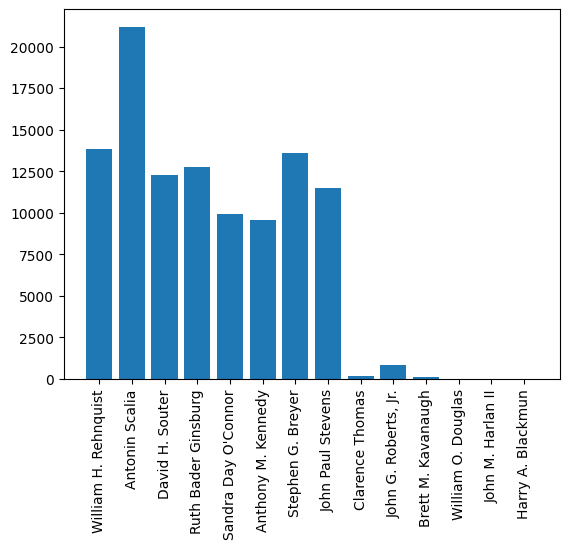

Length of interventions under Rehnquist-7


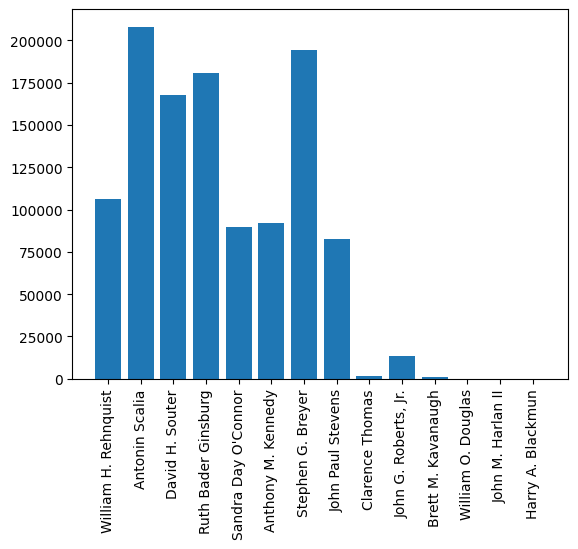

In [109]:
print('Number of interventions under Rehnquist-7')
plot_counts(rehnquist_corpus)
print('Length of interventions under Rehnquist-7')
plot_time(rehnquist_corpus)

Number of interventions under Roberts-4


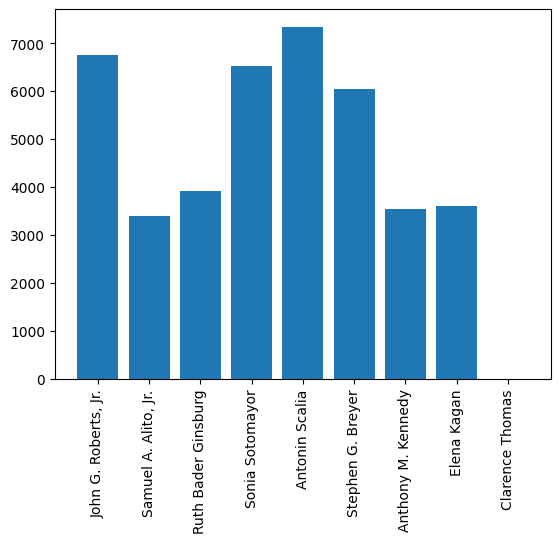

Length of interventions under Roberts-4


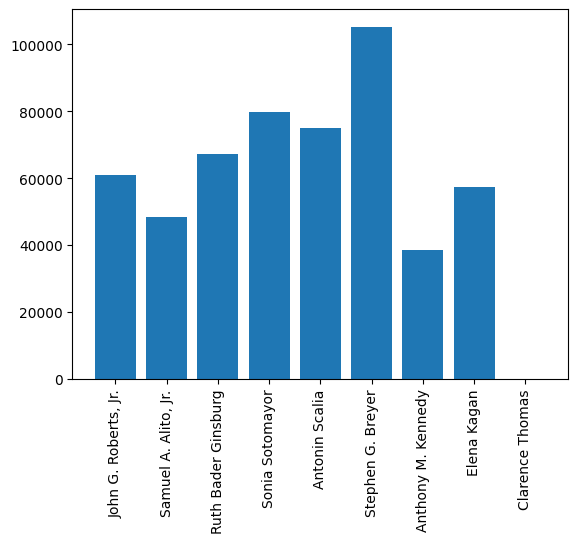

In [110]:
print('Number of interventions under Roberts-4')
plot_counts(roberts_corpus)
print('Length of interventions under Roberts-4')
plot_time(roberts_corpus)

**2.3. CONVERSATIONS AND UTTERANCES**

Each conversation consists of a number of utterances. Given that these are 'natural' conversations (i.e. not in social media, for instance), the structure is lineal. We provide with an example. 

In [56]:
print(list(rehnquist_corpus.iter_conversations())[0].print_conversation_structure())

display(rehnquist_corpus.get_utterances_dataframe().head())

j__william_h_rehnquist
    william_perry_pendley
        j__antonin_scalia
            william_perry_pendley
                j__david_h_souter
                    william_perry_pendley
                        j__david_h_souter
                            william_perry_pendley
                                j__ruth_bader_ginsburg
                                    william_perry_pendley
                                        j__ruth_bader_ginsburg
                                            william_perry_pendley
                                                j__sandra_day_oconnor
                                                    william_perry_pendley
                                                        j__sandra_day_oconnor
                                                            william_perry_pendley
                                                                j__sandra_day_oconnor
                                                                    william_perry_pendley
 

,timestamp,text,speaker,reply_to,conversation_id,meta.case_id,meta.start_times,meta.stop_times,meta.speaker_type,meta.side,meta.timestamp,vectors
id,,,,,,,,,,,,
20706__0_000,None,We'll hear argument first this morning in Numb...,j__william_h_rehnquist,None,20706,1994_93-1841,"[0.0, 11.539]","[11.539, 12.724]",J,None,0.0,[]
20706__0_001,None,Mr. Chief Justice and may it please the Court:...,william_perry_pendley,20706__0_000,20706,1994_93-1841,"[12.724, 15.426, 20.212, 27.317, 39.125, 44.86...","[15.426, 20.212, 27.317, 39.125, 44.862, 52.38...",A,1,12.724,[]
20706__0_002,None,Do we know that that was the reason for the re...,j__antonin_scalia,20706__0_001,20706,1994_93-1841,[87.706],[90.141],J,None,87.706,[]
20706__0_003,None,"Absolutely, Justice Scalia.\nWhen we look at t...",william_perry_pendley,20706__0_002,20706,1994_93-1841,"[90.141, 92.193, 108.019]","[92.193, 108.019, 108.819]",A,1,90.141,[]
20706__0_004,None,Does that clarify that it was the presumption ...,j__david_h_souter,20706__0_003,20706,1994_93-1841,[108.819],[115.375],J,None,108.819,[]


We focus on the possible correlation between the outcome of the case and some features realted to the 'intensity' of the debates. We use the length of the conversation as a proxy for the latter. At the same, we measure the length with 3 indicators: (i) aggregated time of utterances (in minutes), (ii) aggregated number of words in utterances, (iii) number of utterances.
For the three of them, when the petitioner wins, the distribution is more concentrated around the mean, reflecting less divergence among cases bringing to this verdict. This happens in both natural courts. 

Rehnquist-7


,Times,Words,Utters. num,Verdict
20706,58.04,53743,291,1.0
20167,57.95,53349,183,1.0
19907,58.04,54095,187,1.0
21124,58.91,58271,184,1.0
20422,56.45,56074,288,0.0
...,...,...,...,...
21537,99.90,106347,402,0.0
21548,56.67,56318,183,0.0
22658,39.41,38577,136,0.0
21307,60.06,59957,323,1.0


'ALL'

,Times,Words,Utters. num,Verdict
count,866.000000,866.000000,866.000000,865.000000
mean,57.149215,53977.931871,259.718245,0.633526
std,9.641883,9675.644281,62.385537,0.484515
min,0.000000,816.000000,2.000000,0.000000
25%,55.947500,51692.250000,218.000000,0.000000
50%,58.240000,55382.500000,256.000000,1.000000
75%,60.020000,58245.250000,292.000000,1.000000
max,125.600000,117220.000000,549.000000,2.000000


'PETITIONER'

,Times,Words,Utters. num
count,546.000000,546.000000,546.000000
mean,57.408846,54027.631868,259.503663
std,9.650964,10106.119470,63.233577
min,0.000000,816.000000,2.000000
25%,56.005000,51638.000000,219.000000
50%,58.390000,55575.500000,256.500000
75%,60.035000,58317.000000,291.000000
max,125.600000,117220.000000,549.000000


'RESPONDENT'

,Times,Words,Utters. num
count,318.000000,318.000000,318.000000
mean,56.679057,53847.814465,259.993711
std,9.649288,8917.535462,60.953724
min,0.000000,20359.000000,117.000000
25%,55.625000,51880.750000,217.000000
50%,57.835000,55153.000000,254.500000
75%,59.972500,58002.750000,294.750000
max,99.900000,106347.000000,490.000000


Petitioner wins


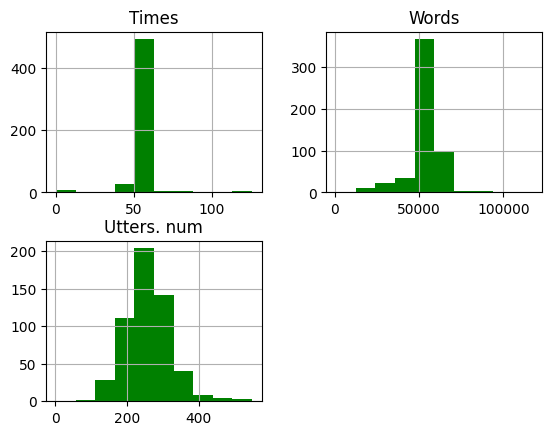

Respondent wins


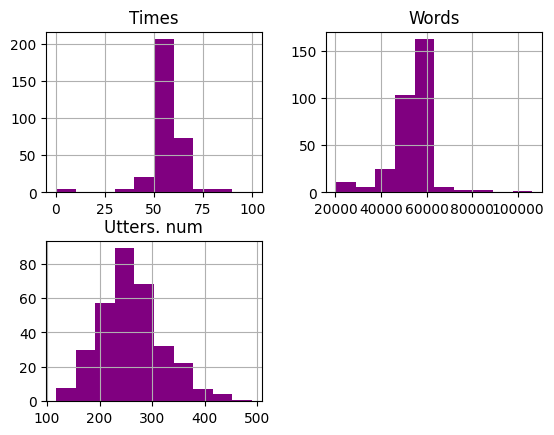

In [113]:
# dictionary, where each element is a conversation:
#   the key is the conv id, and
#   the value is a df with all the utterances of the conv
utts = dict()
case_win = dict()

for conv in rehnquist_corpus.iter_conversations():
    if conv not in utts:
        utts[conv.id] = Conversation.get_utterances_dataframe(conv)
        case_win[conv.id] = conv.meta['win_side']
    else:
        print('error')  # for debugging


len_times = dict()
len_words = dict()
len_num = dict()
for conv_id, df in utts.items():
    len_times[conv_id] = round((df.loc[:,'meta.stop_times'].apply(lambda x: float(x[-1]) if x[-1]!=0 else None) - df.loc[:,'meta.start_times'].apply(lambda x: float(x[0]))).sum()/60,2)
    len_words[conv_id] = df.loc[:,'text'].str.len().sum()
    len_num[conv_id] = df.shape[0]

conv_len = pd.DataFrame({'Times':len_times, 'Words': len_words, 'Utters. num': len_num, 'Verdict':case_win})

print('Rehnquist-7')
display(conv_len)
display('ALL', conv_len.describe())
display('PETITIONER', conv_len.loc[conv_len.loc[:,'Verdict']==1,['Times', 'Words', 'Utters. num']].describe())
display('RESPONDENT', conv_len.loc[conv_len.loc[:,'Verdict']==0,['Times', 'Words', 'Utters. num']].describe())

conv_len.loc[conv_len.loc[:,'Verdict']==1,['Times', 'Words', 'Utters. num']].hist(color = 'green')
print('Petitioner wins')
plt.show()
print('Respondent wins')
conv_len.loc[conv_len.loc[:,'Verdict']==0,['Times', 'Words', 'Utters. num']].hist(color = 'purple')
plt.show()

Roberts-4


,Times,Words,Utters. num,Verdict
22372,60.28,53981,197,0
21694,75.83,73062,255,1
22462,61.11,55761,265,1
21834,59.97,58596,204,1
23016,56.93,57798,134,1
...,...,...,...,...
24014,60.13,62519,190,1
24003,73.78,71182,301,1
24018,61.18,65773,254,0
23997,61.89,60832,294,1


'ALL'

,Times,Words,Utters. num,Verdict
count,361.000000,361.000000,361.000000,361.000000
mean,60.330748,58246.083102,221.847645,0.639889
std,8.575044,9237.735829,55.063464,0.480699
min,4.400000,3293.000000,1.000000,0.000000
25%,58.250000,54542.000000,186.000000,0.000000
50%,60.330000,57748.000000,219.000000,1.000000
75%,61.270000,60667.000000,253.000000,1.000000
max,120.130000,118218.000000,420.000000,1.000000


'PETITIONER'

,Times,Words,Utters. num
count,231.000000,231.000000,231.000000
mean,59.334026,57224.285714,217.333333
std,6.546584,7307.300461,50.267257
min,4.400000,3293.000000,1.000000
25%,58.065000,54457.000000,182.000000
50%,60.230000,57725.000000,217.000000
75%,61.175000,60639.500000,245.500000
max,90.250000,89302.000000,420.000000


'RESPONDENT'

,Times,Words,Utters. num
count,130.000000,130.000000,130.000000
mean,62.101846,60061.738462,229.869231
std,11.128822,11736.747053,62.087634
min,41.300000,36136.000000,85.000000
25%,58.690000,54621.500000,189.000000
50%,60.455000,57883.000000,226.500000
75%,61.587500,61222.750000,270.000000
max,120.130000,118218.000000,412.000000


Petitioner wins


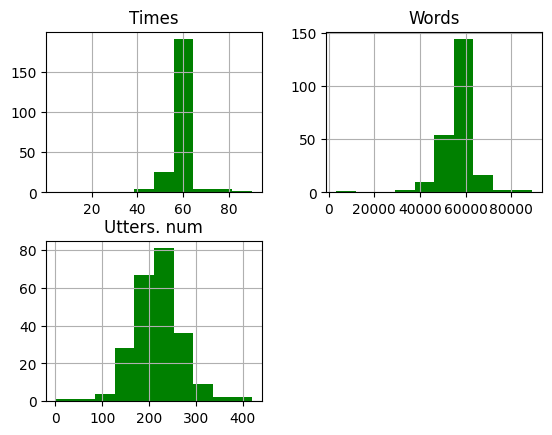

Respondent wins


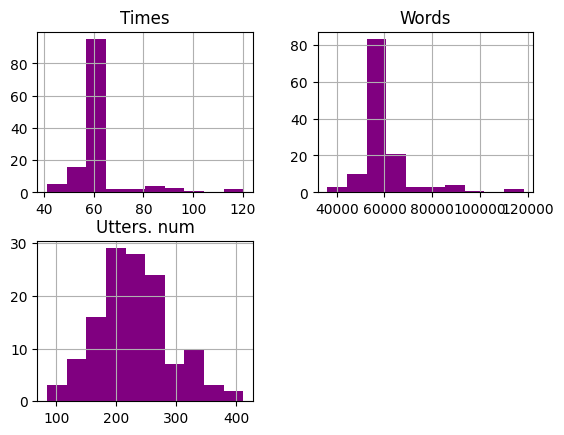

In [112]:
utts = dict()
case_win = dict()

for conv in roberts_corpus.iter_conversations():
    if conv not in utts:
        utts[conv.id] = Conversation.get_utterances_dataframe(conv)
        case_win[conv.id] = conv.meta['win_side']
    else:
        print('error')  # for debugging


len_times = dict()
len_words = dict()
len_num = dict()
for conv_id, df in utts.items():
    len_times[conv_id] = round((df.loc[:,'meta.stop_times'].apply(lambda x: float(x[-1]) if x[-1]!=0 else None) - df.loc[:,'meta.start_times'].apply(lambda x: float(x[0]))).sum()/60,2)
    len_words[conv_id] = df.loc[:,'text'].str.len().sum()
    len_num[conv_id] = df.shape[0]

conv_len = pd.DataFrame({'Times':len_times, 'Words': len_words, 'Utters. num': len_num, 'Verdict':case_win})

print('Roberts-4')
display(conv_len)
display('ALL', conv_len.describe())
display('PETITIONER', conv_len.loc[conv_len.loc[:,'Verdict']==1,['Times', 'Words', 'Utters. num']].describe())
display('RESPONDENT', conv_len.loc[conv_len.loc[:,'Verdict']==0,['Times', 'Words', 'Utters. num']].describe())

conv_len.loc[conv_len.loc[:,'Verdict']==1,['Times', 'Words', 'Utters. num']].hist(color = 'green')
print('Petitioner wins')
plt.show()
conv_len.loc[conv_len.loc[:,'Verdict']==0,['Times', 'Words', 'Utters. num']].hist(color = 'purple')
print('Respondent wins')
plt.show()

### Part 3. Text Pre-processing and Further Analysis
As a final stage, we dig deeper in our data and analyse the content of the text of the utterances.

First, we undertake an analysis of the most salient words.

In [73]:
roberts_win_loss_fw = FightingWords(obj_type='conversation')
roberts_win_loss_fw.fit(roberts_corpus, class1_func = lambda convo: convo.meta['win_side'] == 1,
       class2_func = lambda convo: convo.meta['win_side'] == 0)

Initializing default CountVectorizer with ngram_range (1, 3)... Done.
class1_func returned 231 valid corpus components. class2_func returned 130 valid corpus components.
Vocab size is 15000
Comparing language...
ngram zscores computed.


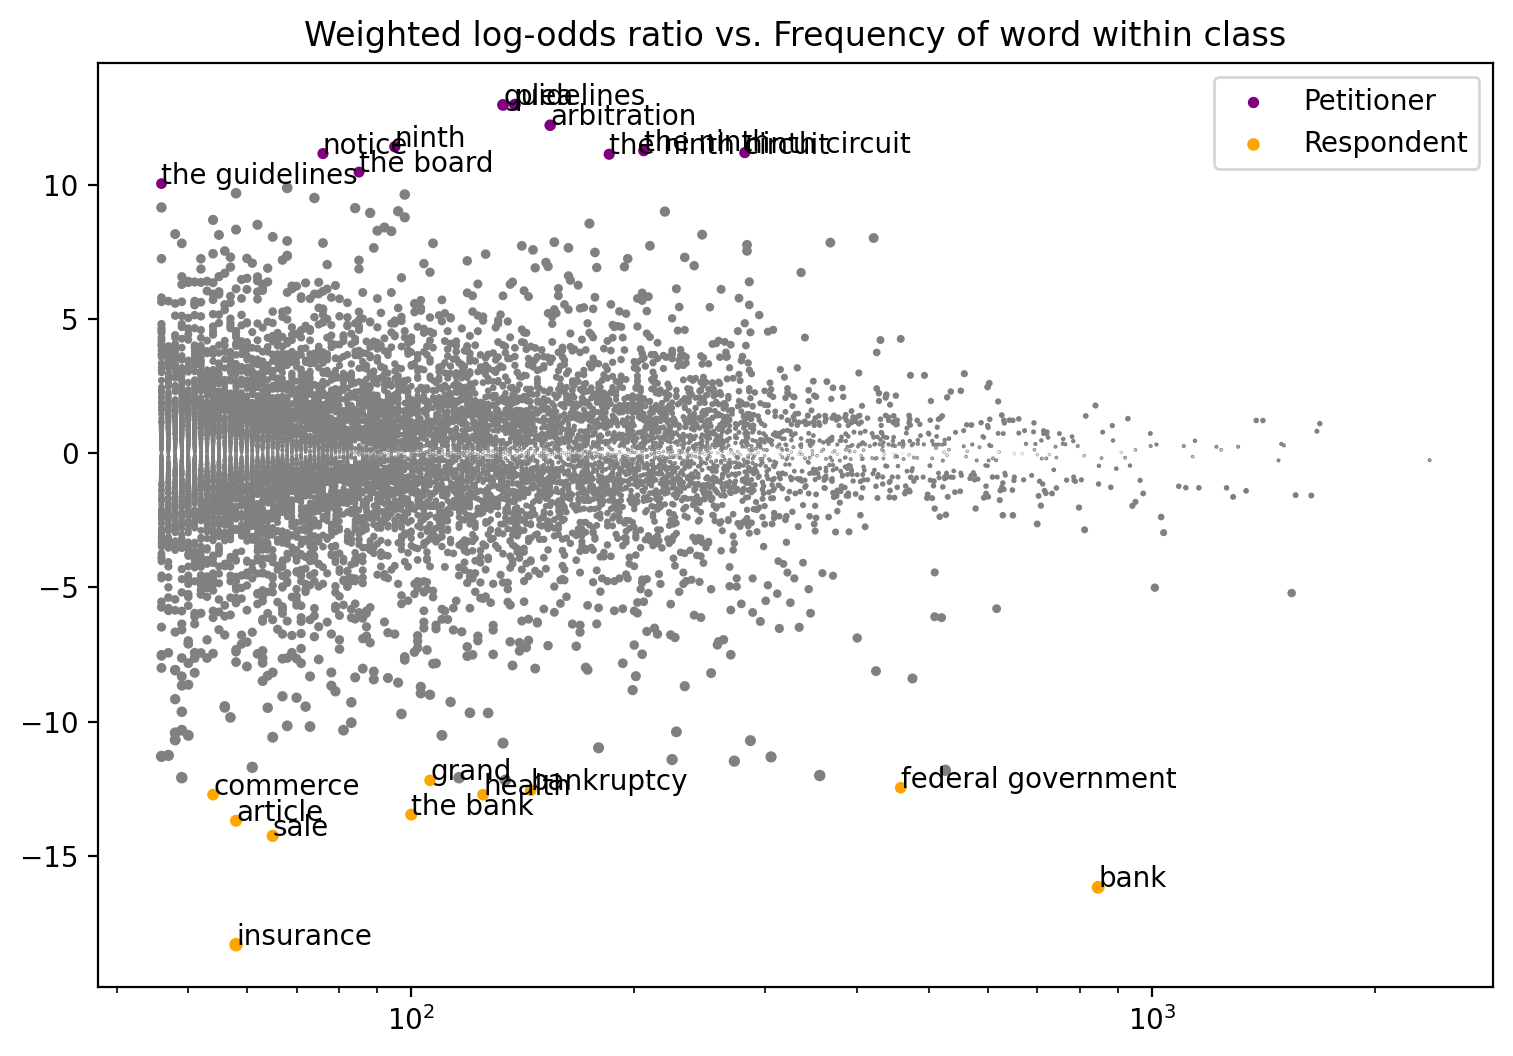

,z-score,class
ngram,,
insurance,-18.319854,Respondent
bank,-16.181708,Respondent
sale,-14.263258,Respondent
article,-13.699358,Respondent
the bank,-13.469425,Respondent
...,...,...
the ninth,11.285039,Petitioner
ninth,11.431986,Petitioner
arbitration,12.235578,Petitioner


In [74]:
roberts_win_loss_fw.summarize(roberts_corpus, plot=True, class1_name='Petitioner', class2_name='Respondent')

In [75]:
# top 20 words for wins and top 20 words for losses
roberts_win_loss_fw.get_top_k_ngrams(20)

(['plea',
  'guidelines',
  'arbitration',
  'ninth',
  'the ninth',
  'ninth circuit',
  'notice',
  'the ninth circuit',
  'the board',
  'the guidelines',
  'sentencing',
  'board',
  'contract',
  'law enforcement',
  'sixth',
  'fda',
  'complaint',
  'treaty',
  'crime',
  'crimes'],
 ['insurance',
  'bank',
  'sale',
  'article',
  'the bank',
  'health',
  'commerce',
  'bankruptcy',
  'federal government',
  'grand',
  'the federal government',
  'water',
  'cocaine',
  'the senate',
  'expenses',
  'conspiracy',
  'fee',
  'grand jury',
  'costs',
  'protection'])

In [76]:
roberts_win_loss_fw.get_ngram_zscores(class1_name='Petitioner', class2_name='Respondent')

,z-score,class
ngram,,
insurance,-18.319854,Respondent
bank,-16.181708,Respondent
sale,-14.263258,Respondent
article,-13.699358,Respondent
the bank,-13.469425,Respondent
...,...,...
the ninth,11.285039,Petitioner
ninth,11.431986,Petitioner
arbitration,12.235578,Petitioner


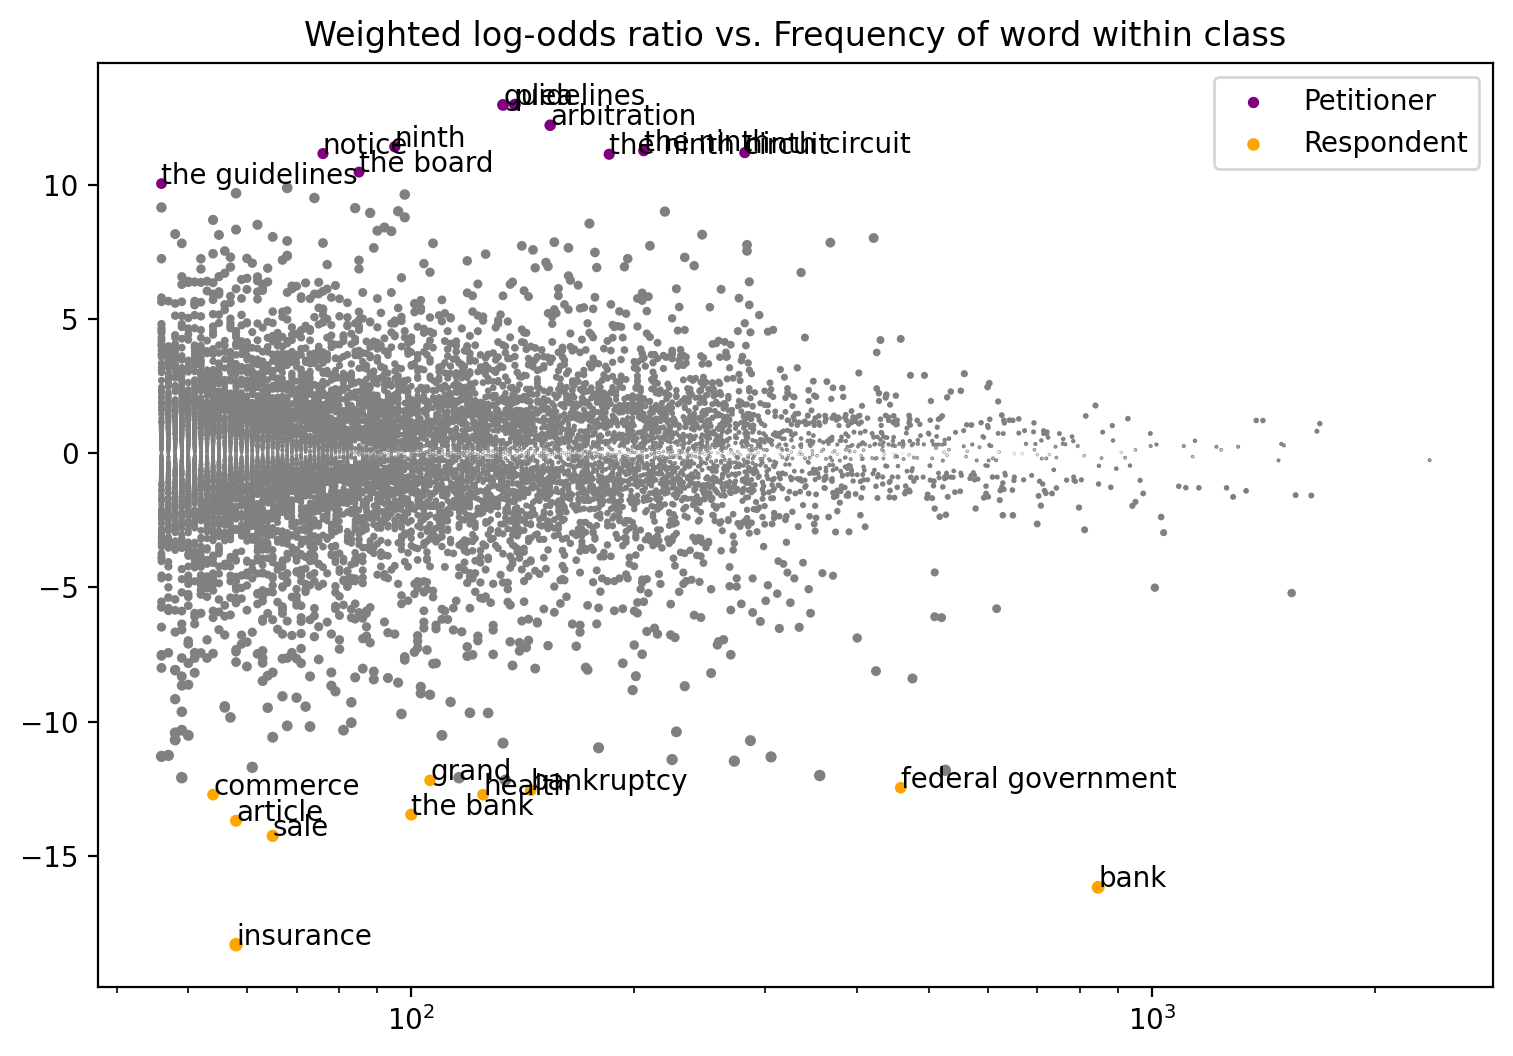

In [77]:
roberts_win_loss_fw.plot_fighting_words(class1_name='Petitioner', class2_name='Respondent')

In [78]:
# data analysis on rehnquist corpus
rehnquist_win_loss_fw = FightingWords(obj_type='conversation')
rehnquist_win_loss_fw.fit(rehnquist_corpus, class1_func = lambda convo: convo.meta['win_side'] == 1,
       class2_func = lambda convo: convo.meta['win_side'] == 0)

Initializing default CountVectorizer with ngram_range (1, 3)... Done.
class1_func returned 546 valid corpus components. class2_func returned 318 valid corpus components.
Vocab size is 15000
Comparing language...
ngram zscores computed.


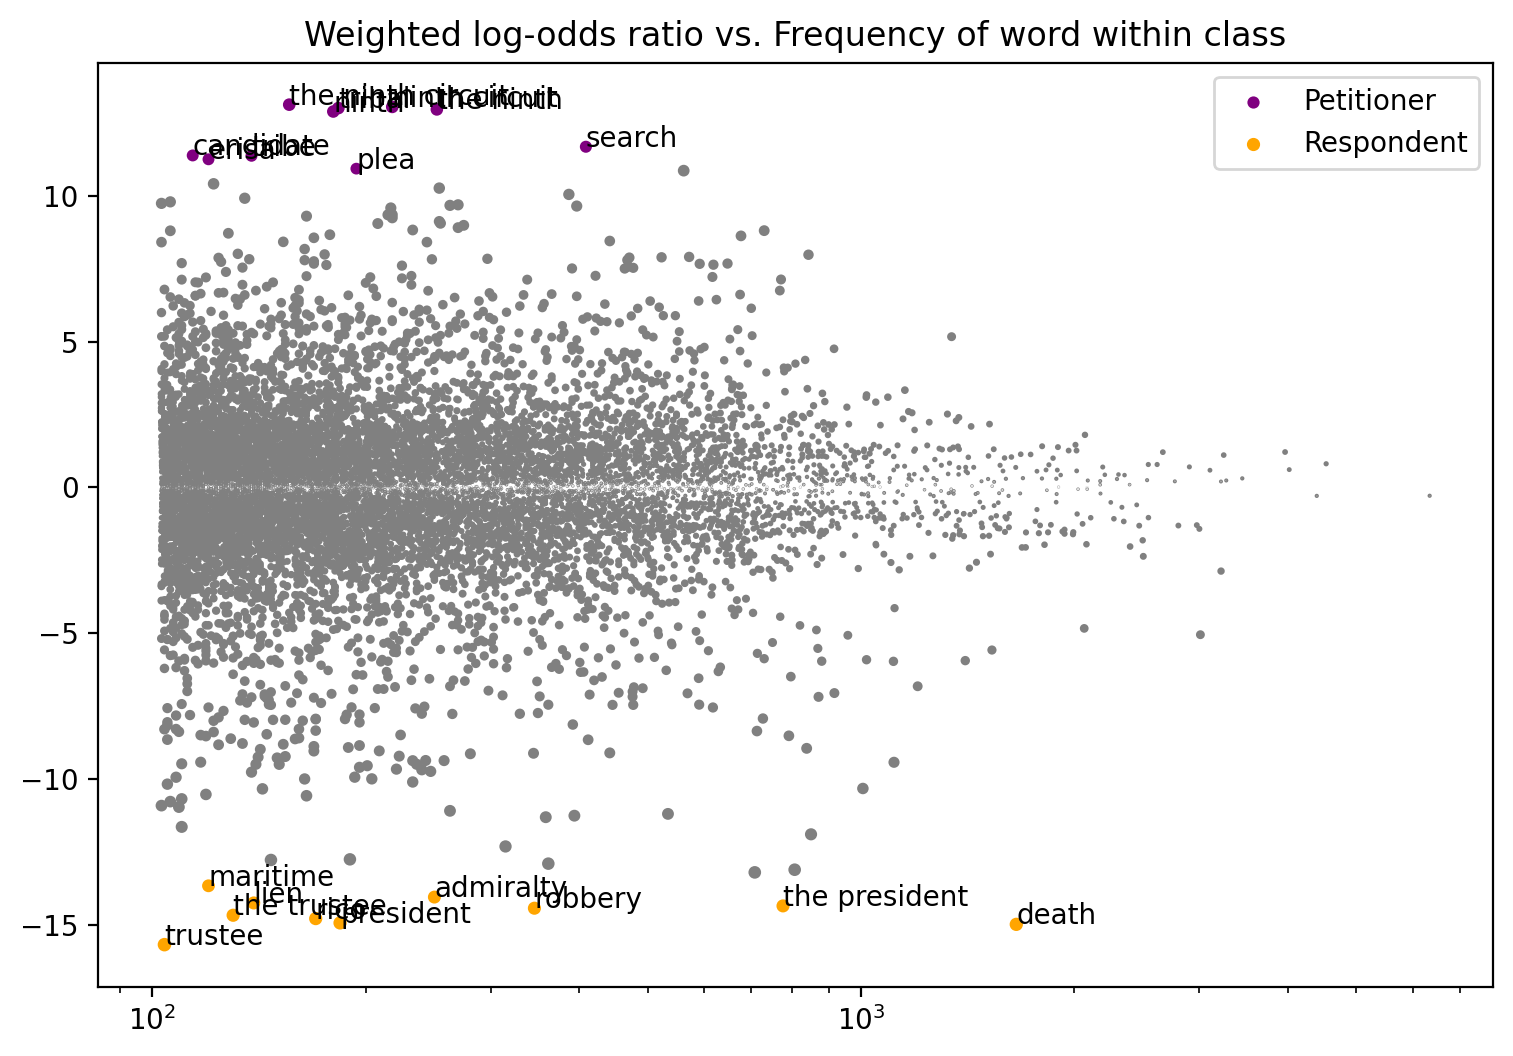

,z-score,class
ngram,,
trustee,-15.681347,Respondent
death,-14.984939,Respondent
president,-14.935863,Respondent
rico,-14.787204,Respondent
the trustee,-14.672974,Respondent
...,...,...
ninth,12.893811,Petitioner
the ninth,12.966270,Petitioner
tribal,13.012222,Petitioner


In [79]:
rehnquist_win_loss_fw.summarize(rehnquist_corpus, plot=True, class1_name='Petitioner', class2_name='Respondent')

In [123]:
rehn_top_100 = rehnquist_win_loss_fw.get_top_k_ngrams(100)
rehn_top_100

(['the ninth circuit',
  'ninth circuit',
  'tribal',
  'the ninth',
  'ninth',
  'search',
  'candidate',
  'tribe',
  'erisa',
  'plea',
  'coal',
  'the tribe',
  'candidates',
  'contributions',
  'social security',
  'information',
  'contribution',
  'statements',
  'miranda',
  'price',
  'tariff',
  'testimony',
  'schools',
  'dangerousness',
  'privacy',
  'fund',
  'lease',
  'consent',
  'university',
  'mark',
  'political',
  'plans',
  'witnesses',
  'the university',
  'montana',
  'funding',
  'law enforcement',
  'fourth',
  'police',
  'disclosure',
  'grand jury',
  'bus',
  'sex',
  'summary',
  'strickland',
  'security',
  'mandate',
  'rates',
  'summary judgment',
  'postal',
  'treasury',
  'indian',
  'the police',
  'ii',
  'pleading',
  'corporation',
  'flood',
  'jurors',
  'campaign',
  'grand',
  'service',
  'illinois',
  'tax court',
  'the social',
  'williams',
  'the social security',
  'corruption',
  'organization',
  'social',
  'of privacy',
  

In [82]:
rehnquist_win_loss_fw.get_ngram_zscores(class1_name='Petitioner', class2_name='Respondent')

,z-score,class
ngram,,
trustee,-15.681347,Respondent
death,-14.984939,Respondent
president,-14.935863,Respondent
rico,-14.787204,Respondent
the trustee,-14.672974,Respondent
...,...,...
ninth,12.893811,Petitioner
the ninth,12.966270,Petitioner
tribal,13.012222,Petitioner


Second, we analyse the questions asked by all speakers including judges. Based on research papers, we add counts of utterances by Petitioners and Respondents since the research papers' methodology used utterances as a proxy for the number of questions that each side had to respond to. 

Citation: Hawes, Timothy. "Computational Analysis of the Conversational Dynamics of the United States Supreme Court", 2009.

The analysis of question and utterance counts by speakers and case verdicts below suggests that the losing side is the side that has more utterances. By analyzing question counts and utterance counts of the speakers (Judge, Advocate (Petitioner or Respondent)), we found that on average, when Petitioners won, Respondents had a greater number of utterances than Petitioners (Roberts 4 court: 4.1 more utterances, Rehnquist 7 court: 5.3 more utterances) Conversely, when Respondents won, Petitioners had a greater number of utterances than Respondents. (Roberts 4 court: 7.7 more utterances, Rehnquist 7 court: 4.0 more utterances) This seems to support existing research indicating that the side that is asked the most questions generally loses (Shullman, Levien 2004). 


Citation: Shullman, Sarah Levien. “The Illusion of Devil’s Advocacy: How the Justices of the Supreme Court Foreshadow Their Decisions During Oral Argument,” J. of Appellate Law & Practice (Vol. 6, No. 2, 2004).

In [86]:
rob_count_df = count_questions(roberts_corpus)
display(rob_count_df) # Question Counts per Conversation, including Utterance Counts for Respondents and Petitioners

rob_all = rob_count_df.mean().to_frame('All (Mean)') # all outcomes
rob_petitioner = rob_count_df.loc[rob_count_df.loc[:,'Verdict']==1,:].mean().to_frame('Petitioner (Mean)') # when Petitioner wins
rob_respondent = rob_count_df.loc[rob_count_df.loc[:,'Verdict']==0,:].mean().to_frame('Respondent (Mean)') # when Respondent wins

roberts_summary = pd.concat([rob_all, rob_petitioner, rob_respondent], axis = 1)
roberts_summary

,Total Questions,Judge Questions,Respondent Q,Respondent U,Petitioner Q,Petitioner U,Unknown,Verdict
22372,75,69,5,46,1,49,0,0
21694,93,89,3,65,1,61,0,1
22462,95,82,12,80,1,28,0,1
21834,79,77,1,27,0,52,0,1
23016,61,53,4,26,4,39,0,1
...,...,...,...,...,...,...,...,...
24014,70,59,4,34,7,38,0,1
24003,96,79,10,66,5,26,0,1
24018,69,58,9,53,2,72,0,0
23997,113,101,6,61,3,55,0,1


,All (Mean),Petitioner (Mean),Respondent (Mean)
Total Questions,79.689751,79.073593,80.784615
Judge Questions,73.750693,73.186147,74.753846
Respondent Q,2.886427,2.887446,2.884615
Respondent U,47.382271,48.173160,45.976923
Petitioner Q,2.445983,2.367965,2.584615
Petitioner U,47.783934,44.731602,53.207692
Unknown,0.000000,0.000000,0.000000
Verdict,0.639889,1.000000,0.000000


In [87]:
rehn_count_df = count_questions(rehnquist_corpus)
rehn_count_df # Question Counts per Conversation, including Utterance Counts for Respondents and Petitioners

display(rehn_count_df)

rehn_all = rehn_count_df.mean().to_frame('All (Mean)') # all outcomes
rehn_petitioner = rehn_count_df.loc[rehn_count_df.loc[:,'Verdict']==1,:].mean().to_frame('Petitioner (Mean)') # when Petitioner wins
rehn_respondent = rehn_count_df.loc[rehn_count_df.loc[:,'Verdict']==0,:].mean().to_frame('Respondent (Mean)') # when Respondent wins

rehn_summary = pd.concat([rehn_all, rehn_petitioner, rehn_respondent], axis = 1)
rehn_summary

,Total Questions,Judge Questions,Respondent Q,Respondent U,Petitioner Q,Petitioner U,Unknown,Verdict
20706,118,108,1,69,6,74,0,1.0
20167,63,56,4,42,3,49,0,1.0
19907,66,62,0,32,1,44,0,1.0
21124,45,41,4,50,0,23,0,1.0
20422,105,100,2,43,3,100,0,0.0
...,...,...,...,...,...,...,...,...
21537,133,128,3,111,2,81,0,0.0
21548,73,68,0,32,5,47,0,0.0
22658,37,36,0,13,1,53,0,0.0
21307,108,97,10,79,1,79,0,1.0


,All (Mean),Petitioner (Mean),Respondent (Mean)
Total Questions,72.599307,73.018315,71.732704
Judge Questions,64.299076,64.236264,64.213836
Respondent Q,2.032333,2.128205,1.880503
Respondent U,57.378753,58.622711,55.154088
Petitioner Q,1.944573,1.822344,2.160377
Petitioner U,55.818707,53.443223,59.855346
Unknown,0.000000,0.000000,0.000000
Verdict,0.633526,1.000000,0.000000


<br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br>

### Assumptions
***

- For example question mark means a real question for justices 
- Cases that there are no conversations for (Roberts has 63 missing with 328 cases covered, rehnquist has 90 missing with 783 cases covered)
- For cases that have multiple conversations for a given case they duplicate the win loss information, so if we are doing anything on a conversation level we need to make sure not to double count win-loss
    - There are 8 cases that have multiple conversations in the Roberts data 
    - There are 3 cases that have multiple conversations in the Rehnquist data
- Court and Years per court:
    - We selected the Roberts-4 natural court (August 07, 2010 - February 13, 2016) and thee Rehnquist-7 natural court(August 03, 1994 - September 28, 2005) 

<br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br>

### Helper Functions
***

In [53]:
##### JUSTICES UTTERANCES ####


def create_dicts(corpus):

    counts_dict = {}
    time_dict = {}
    for convo in corpus.iter_conversations():
        for utt in convo.iter_utterances():
            try:
                if utt.meta['speaker_type'] == 'J': #and utt.speaker.meta['name']=='Clarence Thomas'
                    speaker_name = utt.speaker.meta['name']
    #                 print('SPEAKER**************************', speaker_name)
    #                 print('start_time', utt.meta['start_times'])
    #                 print('stop_times', utt.meta['stop_times'])
                    total_time = utt.meta['stop_times'][-1] - utt.meta['start_times'][0]
                    if total_time < 0:
                        total_time = 0
    #                 print(total_time)
    #                 print(utt.text)
                    if speaker_name not in counts_dict:
                        counts_dict[speaker_name] = 1
                        time_dict[speaker_name] = total_time
                    else:
                        counts_dict[speaker_name] += 1
                        time_dict[speaker_name] += total_time
            except:
                continue
    return counts_dict, time_dict



def plot_counts(corpus):

    x = create_dicts(corpus)[0]

    # counts of utterances per year
    #     counts_dict

    names = list(x.keys())
    values = list(x.values())

    plt.bar(range(len(x)), values, tick_label=names)
    plt.xticks(rotation=90)
    plt.show() 


def plot_time(corpus):
    
    x = create_dicts(corpus)[1]

    # total time speaking per year
    # time_dict

    names = list(x.keys())
    values = list(x.values())

    plt.bar(range(len(x)), values, tick_label=names)
    plt.xticks(rotation=90)
    plt.show()

In [85]:
#### QUESTIONS ASKED ####


def count_questions(corpus):
    """
    This function takes in a corpus and returns a dataframe with the following
    columns per conversation ID:
        Total Questions: Total number of questions asked across all speakers
        Judge Questions: Number of questions asked by Judge
        Respondent Questions: Number of questions asked by Respondent
        Respondent Utterances: Number of utterances by Respondent
        Petitioner Questions: Number of questions asked by Petitioner
        Petitioner Utterances: Number of utterances by Petitioner
        Unknown: number of utterances by Unknown speaker
        Verdict: Case outcome (1 if Petitioner wins, 0 if Respondent wins)
    """

    convo_dict = dict()
    judge_dict = dict()
    advocate0_qdict = dict()
    advocate1_qdict = dict()
    advocate0_udict = dict()
    advocate1_udict = dict()
    unknown_dict = dict()
    case_win = dict()

    for convo in corpus.iter_conversations():
        convo_q_count = 0
        judge_q_count = 0
        advocate0_q_count = 0
        advocate1_q_count = 0
        advocate0_u_count = 0
        advocate1_u_count = 0
        unknown_count = 0
        for utt in convo.iter_utterances():
            convo_q_count += len(re.findall(r"\?", utt.text))
            if utt.meta['speaker_type'] == "A" and utt.meta['side'] == 0:
                advocate0_q_count += len(re.findall(r"\?", utt.text))
                advocate0_u_count += 1
            if utt.meta['speaker_type'] == "A" and utt.meta['side'] == 1:   
                advocate1_q_count += len(re.findall(r"\?", utt.text))
                advocate1_u_count += 1
            if utt.meta['speaker_type'] == "J":
                judge_q_count += len(re.findall(r"\?", utt.text))
            if utt.meta['speaker_type'] == "U":
                unknown_count += len(re.findall(r"\?", utt.text))
        convo_dict[convo.id] = convo_q_count
        judge_dict[convo.id] = judge_q_count
        advocate0_qdict[convo.id] = advocate0_q_count
        advocate1_qdict[convo.id] = advocate1_q_count
        advocate0_udict[convo.id] = advocate0_u_count
        advocate1_udict[convo.id] = advocate1_u_count
        unknown_dict[convo.id] = unknown_count
        case_win[convo.id] = convo.meta['win_side']

    df = pd.DataFrame({'Total Questions': convo_dict,
                    'Judge Questions': judge_dict,
                    'Respondent Q': advocate0_qdict,
                    'Respondent U': advocate0_udict,
                    'Petitioner Q': advocate1_qdict,
                    'Petitioner U': advocate1_udict,
                    'Unknown': unknown_dict,
                    'Verdict':case_win})

    return df